In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
import matplotlib.colors as cl
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.util import add_cyclic_point
from copy import copy  
import pandas as pd
import functools
import os
from glob import glob
import nc_time_axis
import cftime

In [2]:
def trans_z(ds,varname,col,depth,timevar):
    
    exice=np.squeeze(ds['EXCESS_ICE'].values[:,:,col])  
    var=np.squeeze(ds[varname].values[:,:,col])
    zsoi=np.squeeze(ds['ZSOI'].values[:,:,col])[0,:]
    zd=np.where(zsoi<=depth)[0][-1]

    exice_full=exice
    exice=exice[:,:zd]

    zsoi=zsoi[:zd]
    var=var[:,:zd]


    # make zsoi 2D repeating every timeslice
    zsoi=np.expand_dims(zsoi,0)
    
    
    ex_dz=zsoi+exice/917
    subs=np.sum(exice_full[0,:]/917-exice_full/917,axis=1) #surface subcidence
    
    z=ex_dz+ np.repeat(np.expand_dims(subs,axis=1),zd,axis=1) # move the whole coordinate down according to surface elev

    ti=ds[timevar].data # get time variable

    ti=np.expand_dims(ti,1)
    t2=np.repeat(ti,zd,axis=1)
    return t2, z, var

def preprocess (ds, fields):
 "Selescts varaibales, drops lndgrid"
 return ds[fields]

In [3]:
flpth=glob('./subs/hist/*h0.*.nc')

In [4]:
flds=['EXCESS_ICE','DZSOI','ZSOI','TSOI','SUBSIDENCE','SUBSACC']
ds = xr.open_mfdataset(flpth,decode_times=True)
ds = ds[flds]

In [5]:
ds1 = ds.groupby('time.year').mean()
#ds1

(3.0, -0.5)

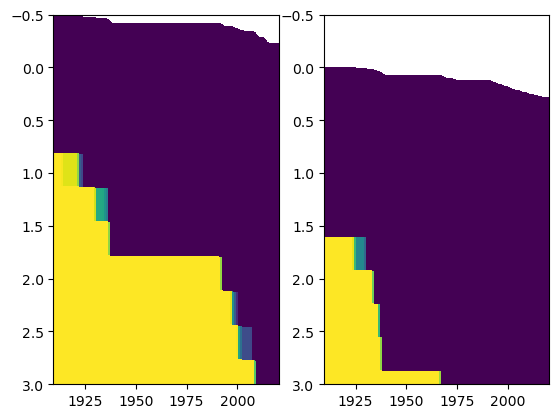

In [6]:
t1,z1,exice1 = trans_z(ds=ds1,varname='EXCESS_ICE',col=0,depth=8,timevar='year')
t2,z2,exice2 = trans_z(ds=ds1,varname='EXCESS_ICE',col=1,depth=8,timevar='year')
dz=np.squeeze(ds1['DZSOI'].values[:,:,1])[0,:]
dz=dz[:exice1.shape[1]]
exice_conc1=exice1/dz/917
exice_conc2=exice2/dz/917
fig, ax = plt.subplots(1,2)
p1=ax[0].pcolor(t1,z1-0.5,exice_conc1)

ax[0].set_ylim(3,-0.5)

p2=ax[1].pcolor(t2,z2,exice_conc2)
#limit pos,neg inverts axis itself
ax[1].set_ylim(3,-0.5)



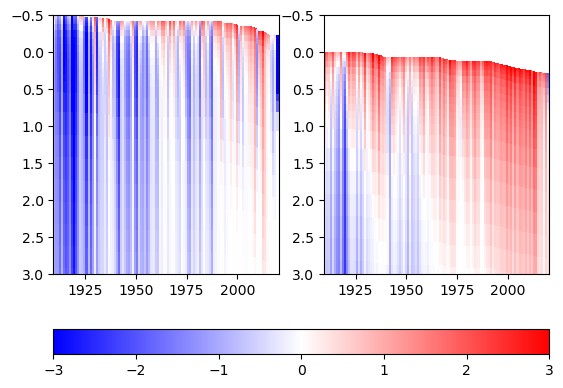

In [7]:
t1,z1,tsoi1 = trans_z(ds=ds1,varname='TSOI',col=0,depth=8,timevar='year')
t2,z2,tsoi2 = trans_z(ds=ds1,varname='TSOI',col=1,depth=8,timevar='year')
cmap=matplotlib.cm.bwr
tsoi1=tsoi1-273.15
tsoi2=tsoi2-273.15
fig, ax = plt.subplots(1,2)
p1=ax[0].pcolor(t1,z1-0.5,tsoi1, vmin=-3, vmax=3,cmap=cmap)
ax[0].set_ylim(3,-0.5)

p2=ax[1].pcolor(t2,z2,tsoi2, vmin=-3, vmax=3,cmap=cmap)
#limit pos,neg inverts axis itself
ax[1].set_ylim(3,-0.5)
fig.colorbar(p1,ax=ax,orientation='horizontal')

In [8]:
varname='TSOI'
dzsoi=np.squeeze(ds['DZSOI'].values[:,:,1])[0,:] # get everything as np.ndarrays
exice=np.squeeze(ds['EXCESS_ICE'].values[-1,:,1])  
var=np.squeeze(ds[varname].values[-1,:,1])
zsoi=np.squeeze(ds['ZSOI'].values[:,:,1])[0,:]
exice_len=exice.shape[0]
exice_len
z_ext=zsoi[:exice_len]+np.cumsum(exice/917) - 0.5 + np.squeeze(ds['SUBSACC'].values[-1,0])
var=var[:exice_len]

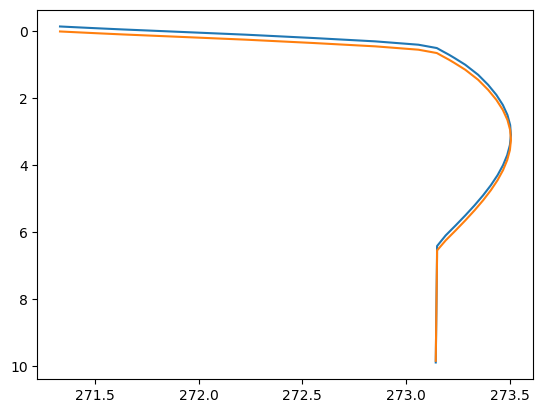

In [9]:
fig, ax = plt.subplots()
ax.plot(var,z_ext)
ax.plot(var,zsoi[:exice_len])
ax.invert_yaxis()

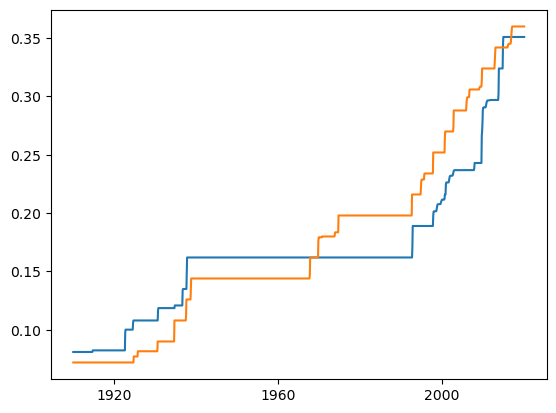

In [10]:
subs=np.squeeze(ds['SUBSACC'].values[:,0])
subs2=np.squeeze(ds['SUBSACC'].values[:,1])
time=ds.time.values
fig, ax = plt.subplots()
ax.plot(time,subs)
ax.plot(time,subs2)